# FPsim Intervention Scenarios
---------------

With FPsim's user-friendly Scenarios API, we can easily setup and compare multiple intervention scenarios against one another to better understand the complex interactions between demographics and family planning behavior.

1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Efficacy](#efficacy)
4. [Switching](#switching)
5. [Initialization/Discontinuation](#initialization)
6. [Parameter changes](#parameter)
7. [Custom interventions](#custom)
8. [Comparison](#comparison)
9. [Appendix](#appendix)

# Introduction <a name="introduction"></a>
-------------
FPsim is a useful tool for understanding how demographics, contraceptive efficacy, and contraceptive uptake behaviors interact with one another. We will be going through a couple of scenarios using our "Scenarios" api, which makes it easier for researchers to customize and compare the results of family planning interventions.



# Setup <a name="setup"></a>
-----------
#### A simple guide on how to set up a basic intervention scenario

Everytime we run an experiment, we want to:
- Run simulations with one as the control and one or more as experimental
- Compare the results between the control sim and experimental sim(s)

The Scenarios object encapsulates this type of inquiry. Each Scenario represents a
distinct set of simulation parameters. Once each Scenario is added
to the Scenarios object, the Scenarios object allows the user to run
simulations easily, and compare the results.

In [1]:
import sciris as sc
import fpsim as fp

C:\fpsim_folder\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\fpsim_folder\venv\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\fpsim_folder\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


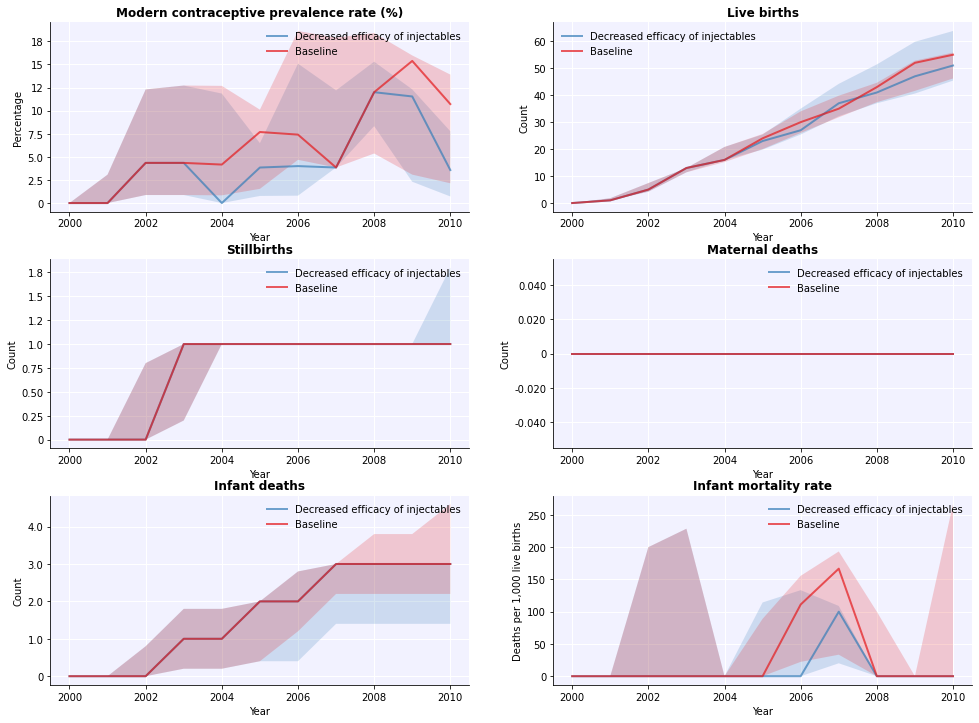

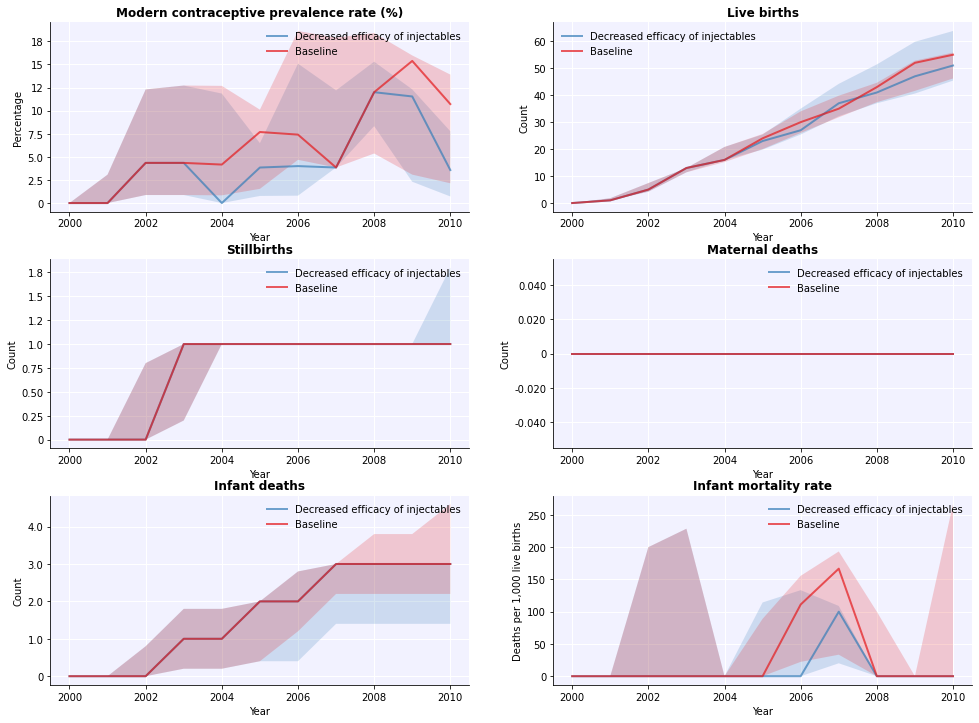

In [2]:
# n (initial population) is a parameter one can increase or decrease to make 
# the output more or less detailed and make the runtime longer or shorter
n = 500 

# First we create a Scenario object where:
#    eff is the dictionary of specifications for how we want to change efficacy
#    year is the year we want to implement the change
#    label is how we want to label the scenario in the visualization
scenario = fp.make_scen(eff={'Injectables':0}, year=2000, label='Decreased efficacy of injectables')

# Then we add it to the Scenarios object which is used to compare results across multiple scenarios
#    repeats defines how many times to run the simulation for each Scenario in order to determine uncertainty intervals.
#    location defines some preset parameters for a speedy sim run (in this case: verbose=False, 10 year run)
sim_parameters = {"n": n, "location": "test", "repeats": 3}
scenarios = fp.Scenarios(scens=scenario, **sim_parameters)

# We are going to add a baseline for comparison
baseline = fp.make_scen(label="Baseline")
scenarios.add_scen(baseline)

# Now that we have the scenario specifications, we can run the simulations
scenarios.run()

# To examine the resulting demoraphic features of the scenario we can use the plot_scens() function
scenarios.plot()

# Efficacy <a name="efficacy"></a>
---------
#### How to to compare sim results across different contraceptive efficacies

Let's suppose we want to better understand how features of the population change at varying levels of efficacy of modern contraceptive methods. For this task we would create three specification dictionaries, add them to scenarios, and then run.

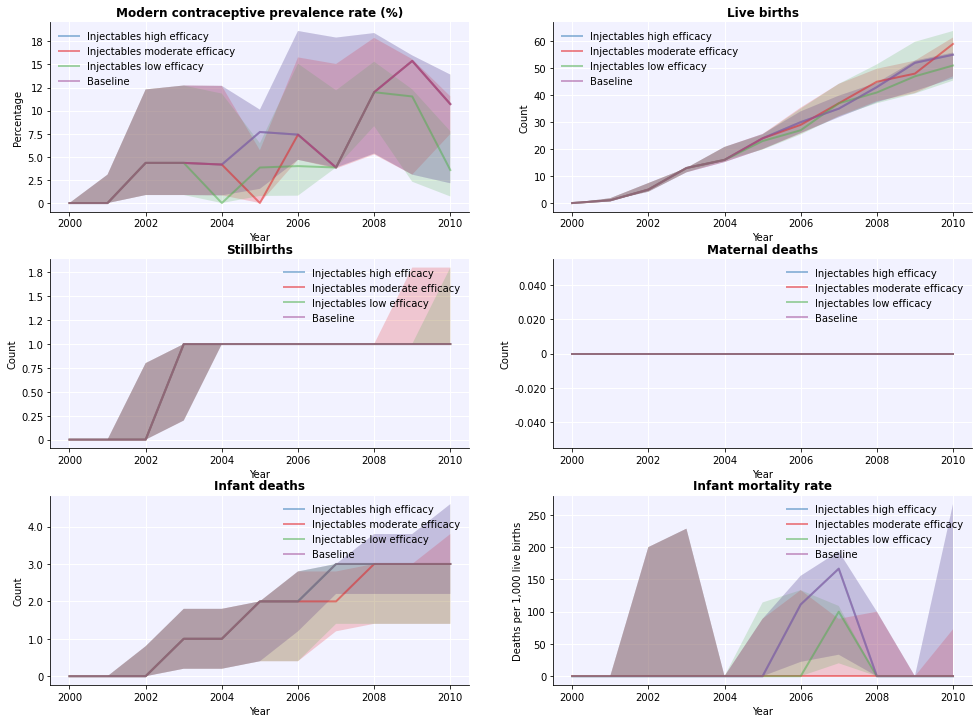

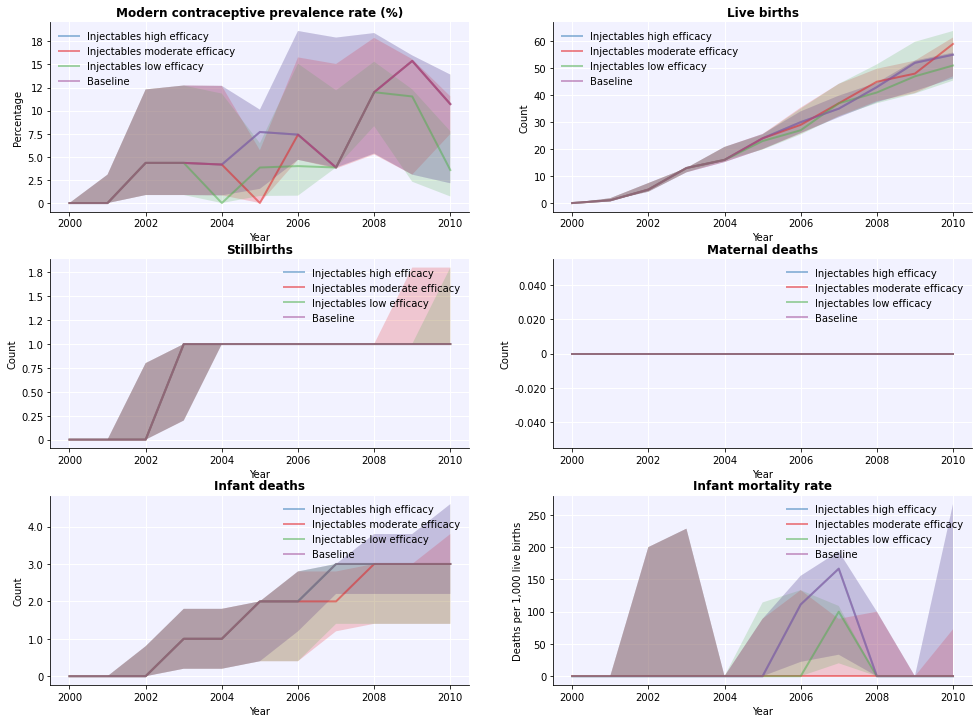

In [3]:
# For any cell, one can change the initial population by setting: sim__parameters['n']
# In order to compare different scenarios to one another we must:

# Define the different scenarios
injectables_1 = fp.make_scen(eff={'Injectables':1.0}, year=2000, label='Injectables high efficacy')

injectables_05 = fp.make_scen(eff={'Injectables':0.5}, year=2000, label='Injectables moderate efficacy')

injectables_0 = fp.make_scen(eff={'Injectables':0}, year=2000, label='Injectables low efficacy')

# Add to scenarios object
scens_eff = fp.Scenarios(scens=[injectables_1, injectables_05, injectables_0, baseline], **sim_parameters)

# Run scenarios
scens_eff.run()

# Compare results
scens_eff.plot()

## Initialization and Discontinuation <a name="initialization"></a> 
--------
#### How to examine  initialization and discontinutation rates
It is often important to examine the probability of beginning a contraceptive method or terminating it. The below steps will demonstrate how to compare varying initialization and discontinuation rates using Scenario keyword arguments:

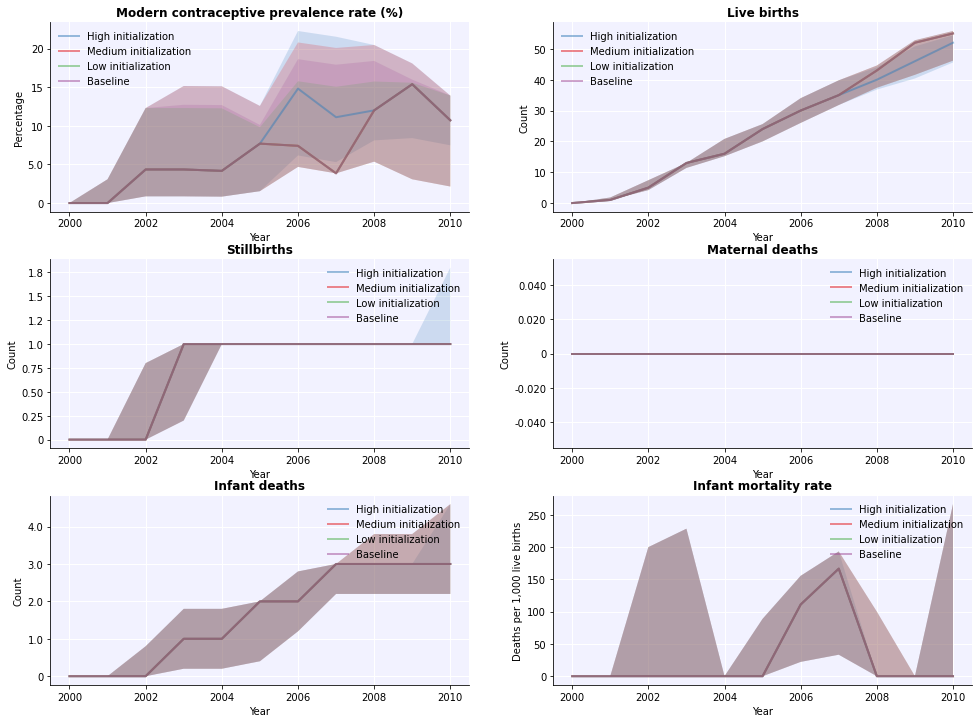

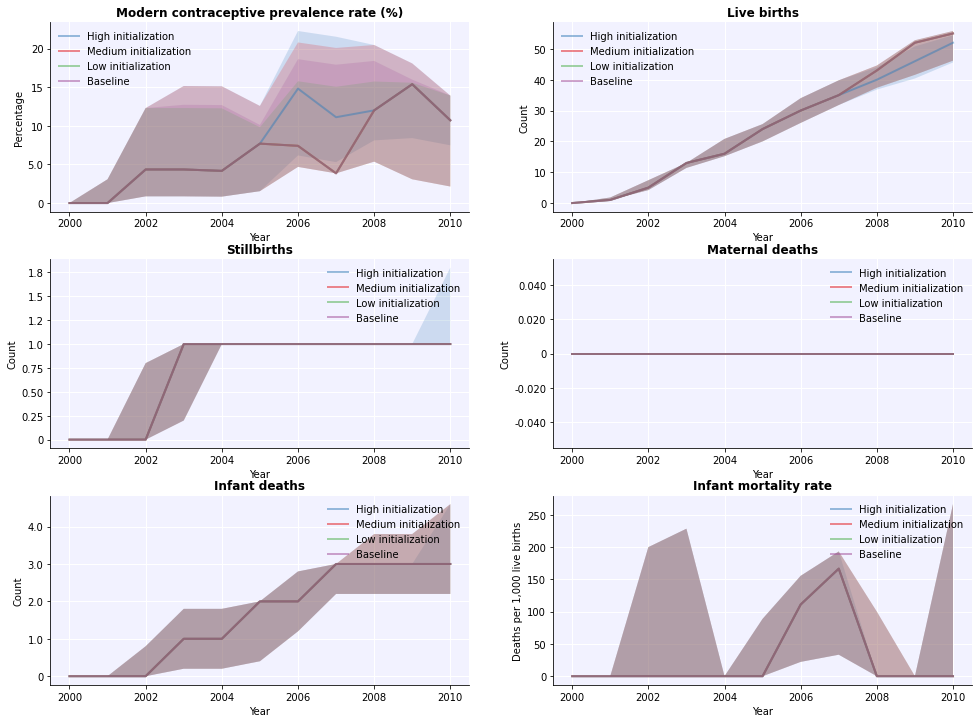

In [4]:
# We can set the initialization factor by using the "method" and "init_factor" args
# This multiplies the probability of switching from None -> method by the value specified in "init_factor"
# One can also set the value explicitly with init_value
kwargs = {'method': 'Injectables', 'year': 2000}
high_init = fp.make_scen(label="High initialization", init_factor=1.5, **kwargs)
medium_init = fp.make_scen(label="Medium initialization", init_factor=1.2, **kwargs)
low_init = fp.make_scen(label="Low initialization", init_factor=0.7, **kwargs)

scens_initialization = fp.Scenarios(scens=[high_init, medium_init, low_init, baseline], **sim_parameters)
scens_initialization.run()
scens_initialization.plot()

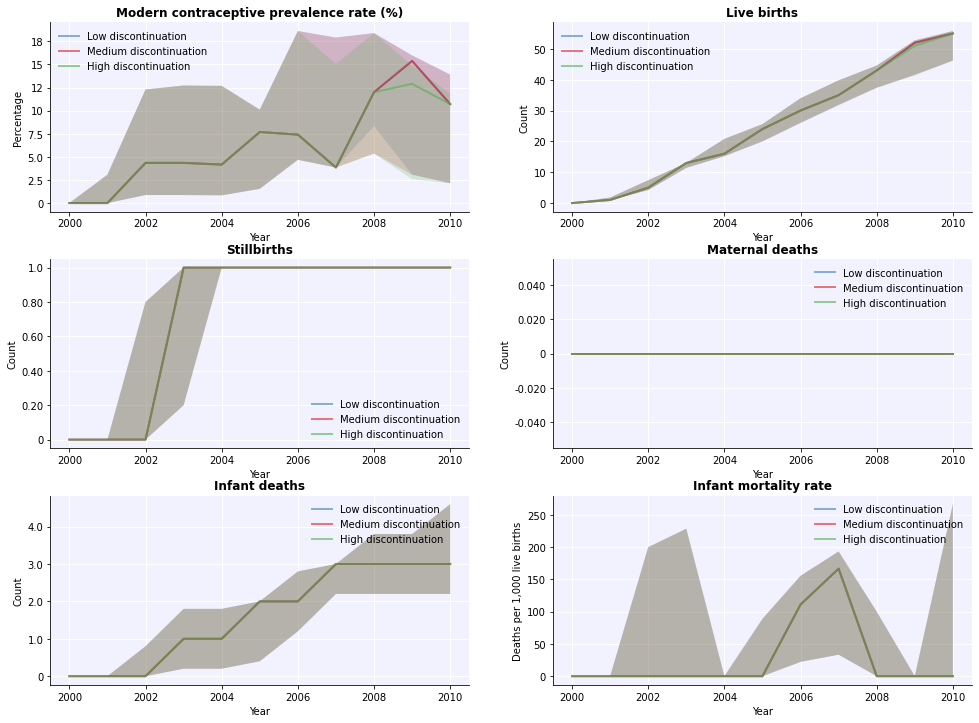

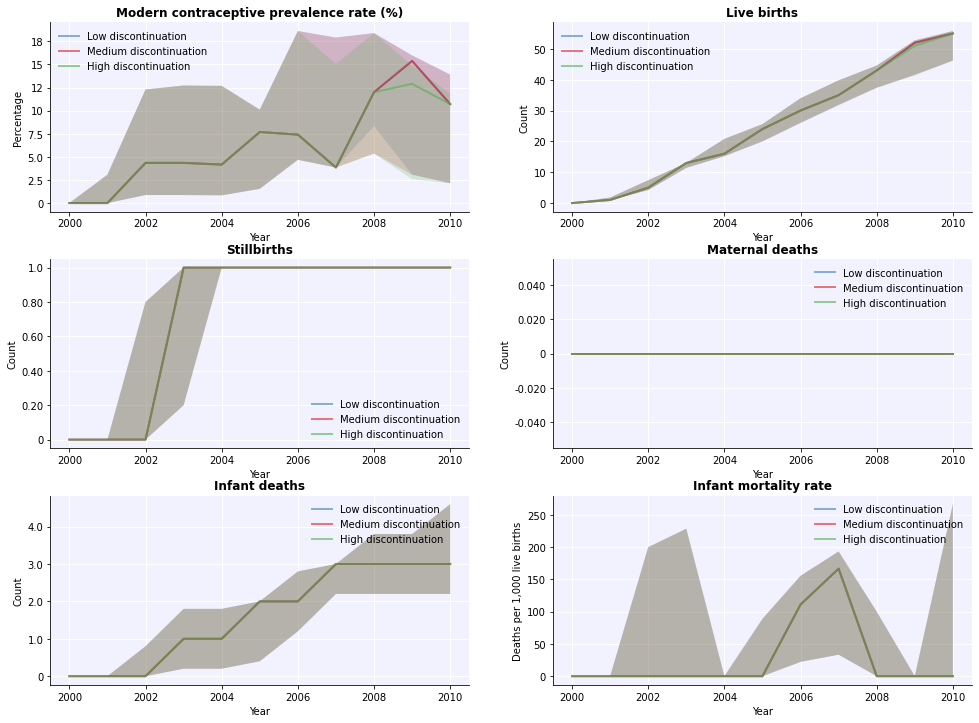

In [5]:
# discont_factor and discont_value are equivalent to init_factor/value except that they affect probability
# of transition from method -> None
high_dis = fp.make_scen(label="High discontinuation", discont_factor=1.5, **kwargs)
medium_dis = fp.make_scen(label="Medium discontinuation", discont_factor=1.2, **kwargs)
low_dis = fp.make_scen(label="Low discontinuation", discont_factor=0.7, **kwargs)

scens_discont = fp.Scenarios(scens=[low_dis, medium_dis, high_dis], **sim_parameters)
scens_discont.run()
scens_discont.plot()

### **Neat trick**
One great feature of Scenario objects is that you can add them together. So we could combine the above scenarios:

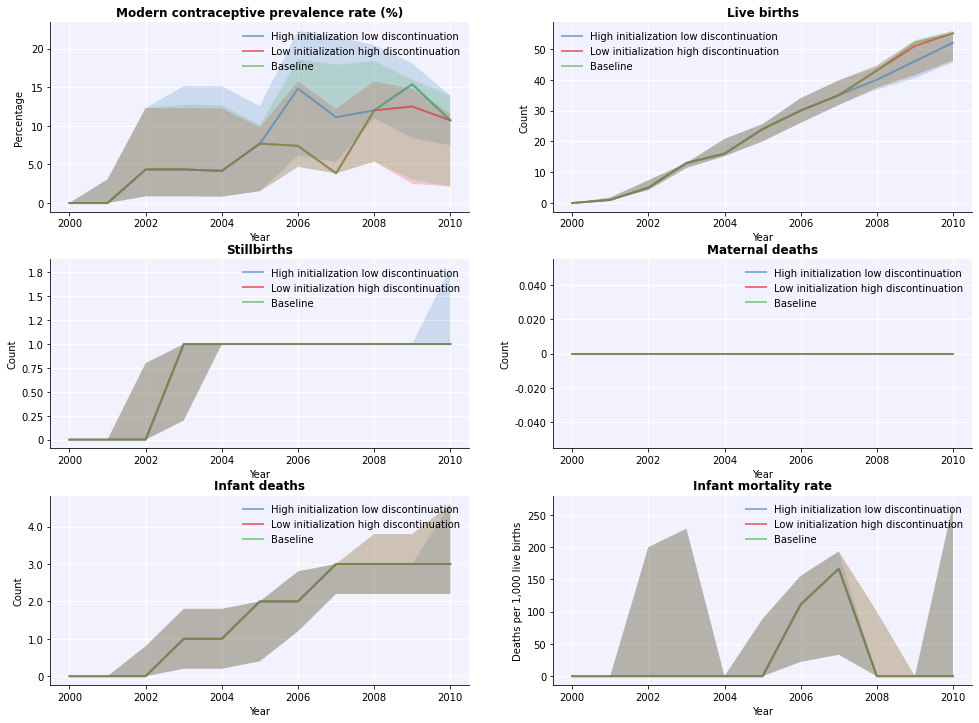

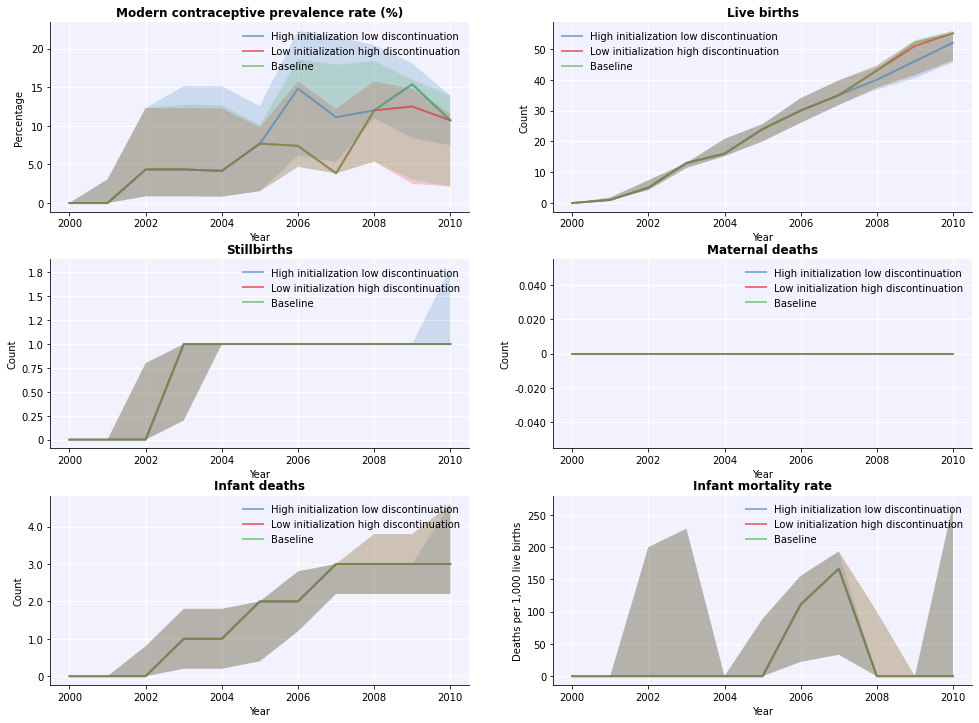

In [6]:
new_scenario = high_init + low_dis
new_scenario2 = low_init + high_dis
new_scenario.label = "High initialization low discontinuation"
new_scenario2.label = "Low initialization high discontinuation"

scens_combined = fp.Scenarios(scens=[new_scenario, new_scenario2, baseline], **sim_parameters)
scens_combined.run()
scens_combined.plot()

# Switching <a name="switching"></a>
-----------
#### How to compare sim results across different switching probabilities.

If we want to understand how the probability of switching from one contraceptive to another affects a population, we may want to sweep this probability and examine the results. Below is how we would do this using Scenarios:

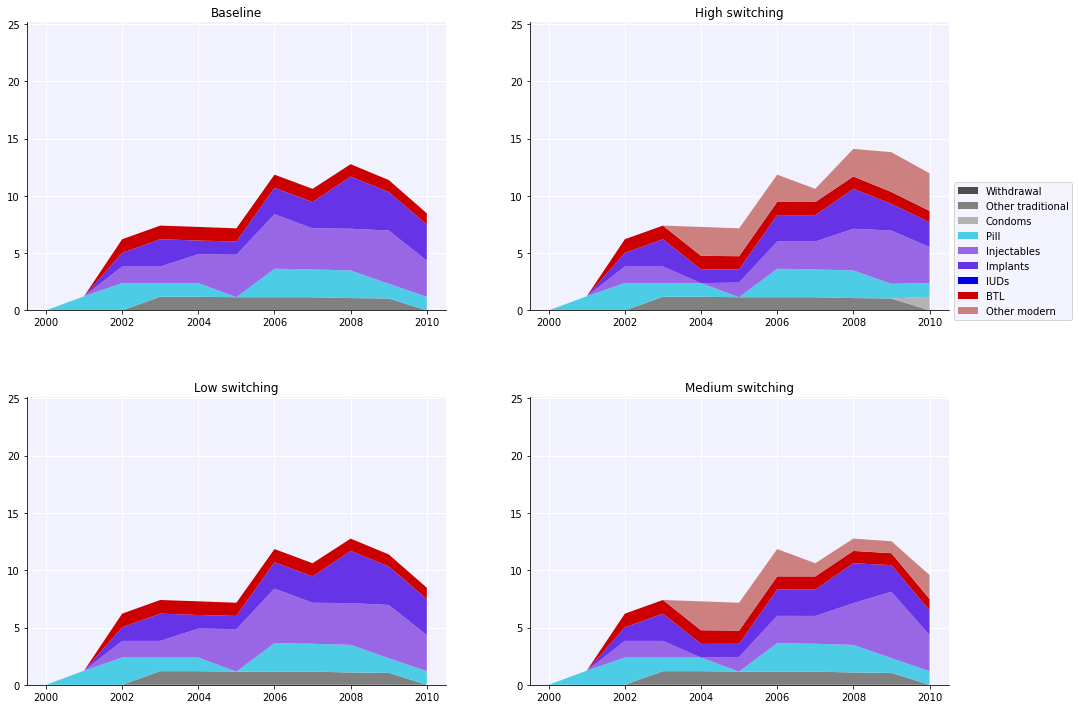

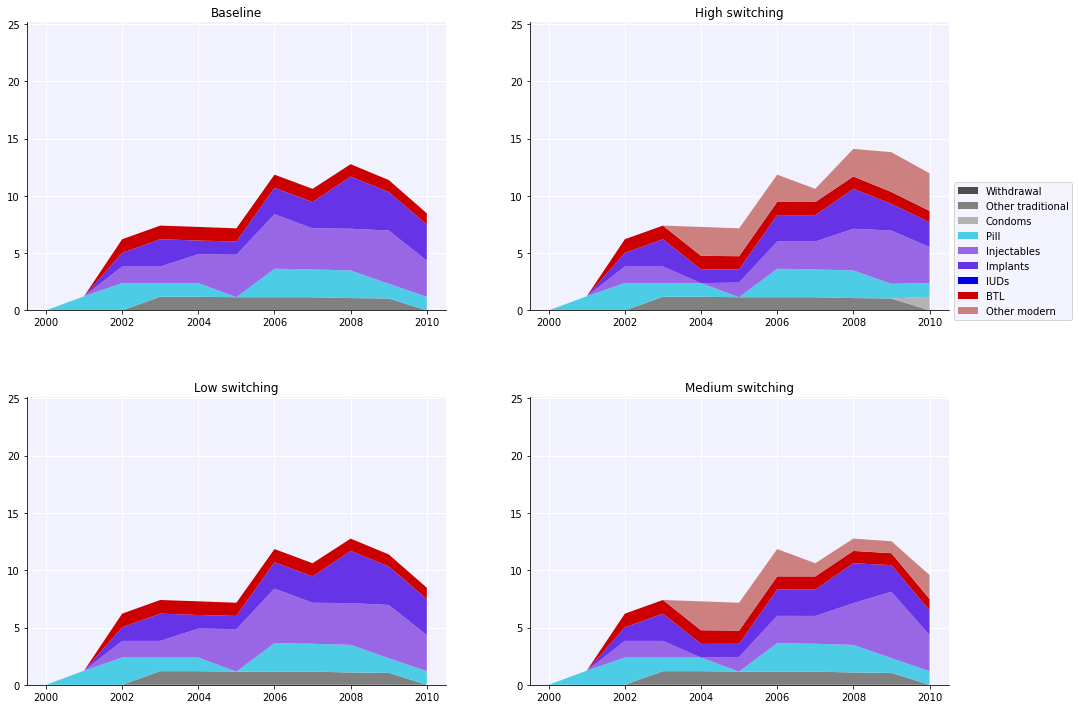

In [29]:
# Within our scenario we can adjust the probability of switching from one intervention (source) to another (dest).
# For the purpose of granular analysis we can even target specific ages (ages), and postpartum status which often affects
# a women's contraceptive uptake behavior. In the below example we target women that are not postpartum
kwargs = {'source': 'Injectables', 'dest': 'Other modern', 'year': 2000, 'ages': ["18-20", "21-25", "26-35"], 'matrix': 'annual'}
high_switching = fp.make_scen(value=1.0, label="high switching", **kwargs)
medium_switching = fp.make_scen(value=0.5, label="medium switching", **kwargs)
low_switching = fp.make_scen(value=0.0, label="low switching", **kwargs)

# Then we pass these scenarios into the Scenarios object as before
scens_switching = fp.Scenarios(scens=[high_switching, medium_switching, low_switching, baseline], **sim_parameters)
scens_switching.run()

# Some custom colors for the plot, also works with custom methods
method_colors = {
    'Withdrawal'        : [0.3, 0.3, 0.3],
    'Other traditional' : [0.5, 0.5, 0.5],
    'Condoms'           : [0.7, 0.7, 0.7],
    'Pill'              : [0.3, 0.8, 0.9],
    'Injectables'       : [0.6, 0.4, 0.9],
    'Implants'          : [0.4, 0.2, 0.9],
    'IUDs'              : [0.0, 0.0, 0.9],
    'BTL'               : [0.8, 0.0, 0.0],
    'Other modern'      : [0.8, 0.5, 0.5]
    }

scens_switching.plot(to_plot='method', colors=method_colors)

# Parameter changes <a name="parameter"></a>
-----------
#### How to change any parameter in the sim at a given year
Anything from the probabilitity of having twins to the exposure factor can be adjusted easily through keyword arguments: 

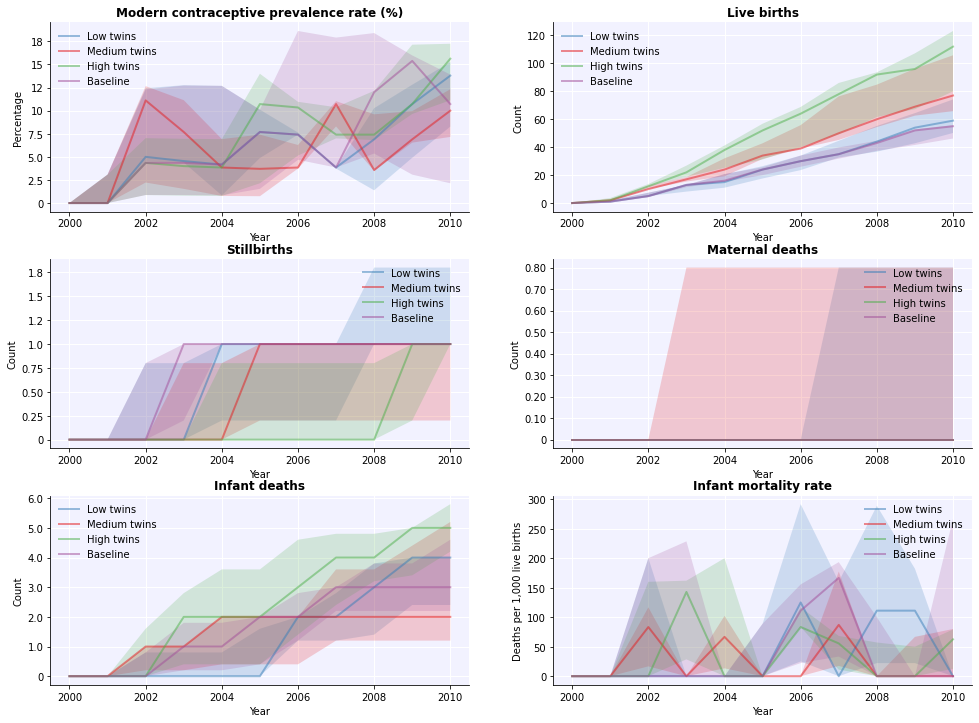

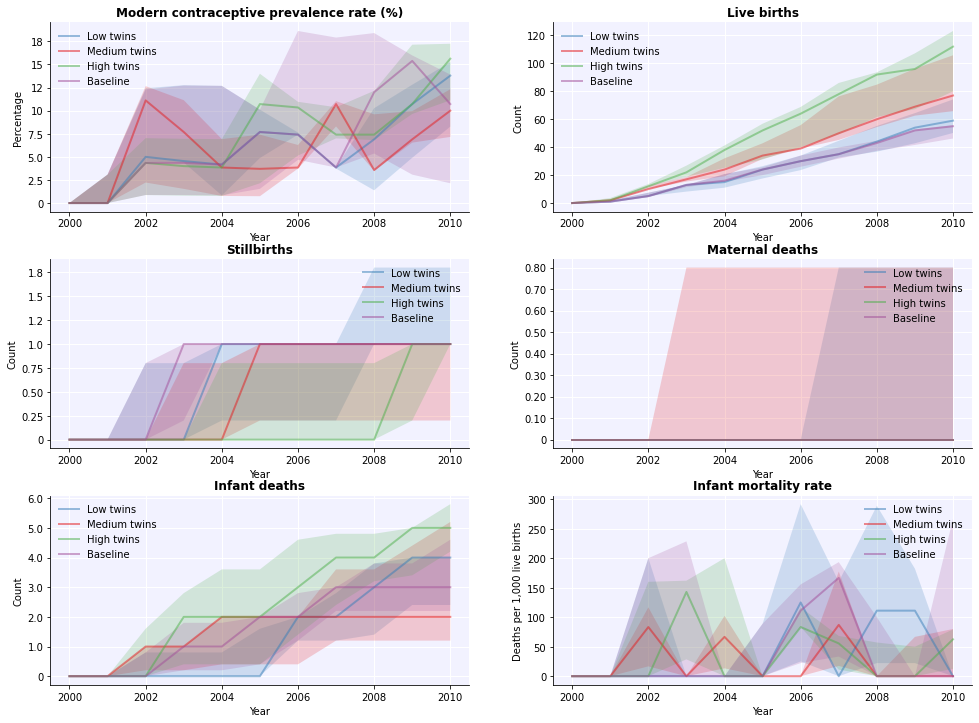

In [8]:
# Here we want to compare different probabilities of giving birth to twins
kwargs = {'par':'twins_prob', 'par_years':2000}
low_twins = fp.make_scen(label="Low twins", par_vals=0.1, **kwargs)
medium_twins = fp.make_scen(label="Medium twins", par_vals=0.5, **kwargs)
high_twins = fp.make_scen(label="High twins", par_vals=1.0, **kwargs)

scens_combined = fp.Scenarios(scens=[low_twins, medium_twins, high_twins, baseline], **sim_parameters)
scens_combined.run()
scens_combined.plot()

Specifically you can change any parameter in **People.pars** or **Sim.people.pars**, an exhaustive list of which can be found with `Scenarios.msims[0].pars.keys()`

# Custom interventions <a name="custom"></a>
------------
#### How to define a function that changes something in the model as it runs
As a sim runs, it applies "interventions" at each step. We've utilized built-in interventions from **Scenarios** for the past few sections. If none of the existing interventions are sufficient, it is possible to define and run one's own intervention:

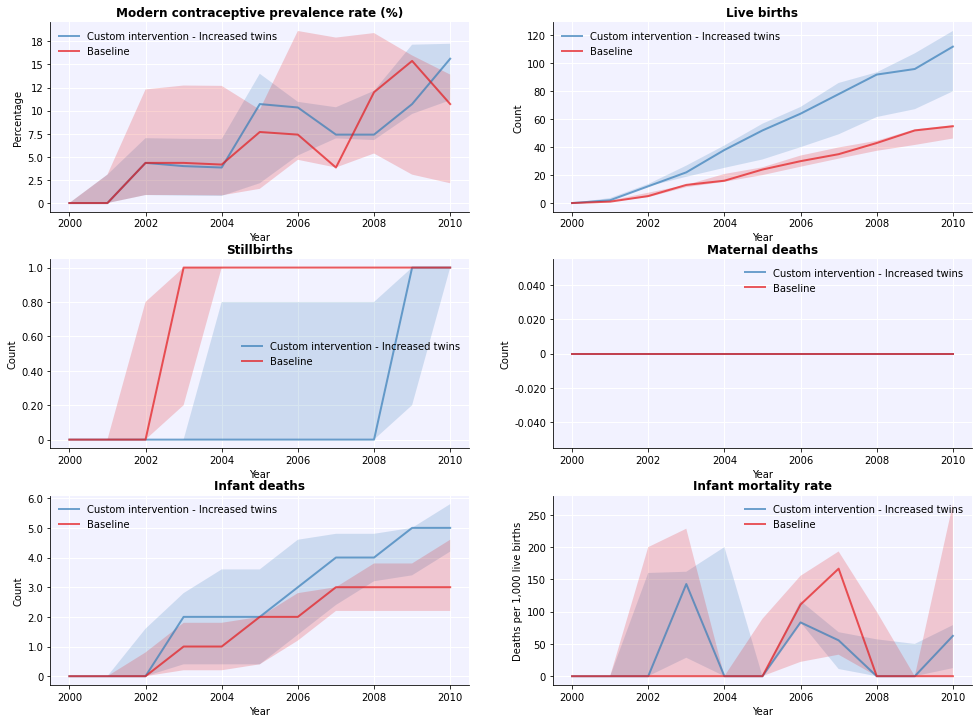

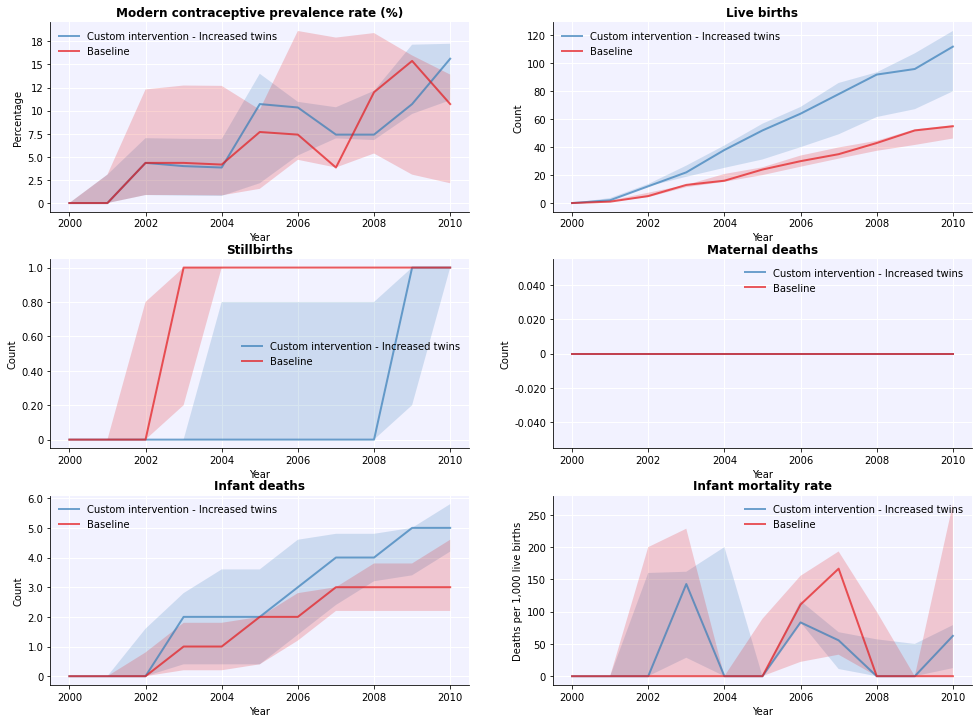

In [9]:
# At each step, the sim itself is passed into the intervention. This allows
# the user to access and change sim.People.pars, or parameters of the sim

# To acomplish the "high twins" scenario from before, we would say:
def update_sim(sim): 
    if sim.y == 2000.0:
        sim.people.pars['twins_prob'] = 1.0
        
custom_scenario = fp.make_scen(interventions=update_sim, label="Custom intervention - Increased twins")
        
new_scen = fp.Scenarios(scens=[custom_scenario, baseline], **sim_parameters)
new_scen.run()

new_scen.plot()

**Warning**: This is an advanced use of Scenarios and requires some knowledge of the inner workings of the **Sim** class

# Comparison <a name="comparison"></a>
---------
#### How to compare sim results in different ways

The Scenarios object has a number of methods for plotting results across different scenarios. **plot()** gives us a grid of relevant plots about the Scenarios with confidence intervals derived from the seeds of each Scenario. There are also custom sets of visualizations accessed by the **to_plot** parameter, with themes such as adverse pregnancy outcomes and mortality.

**plot_sims()** is similar but shows us the results of each individual sim run, and **analyze_sims()** logs the results of the run as a pandas DataFrame.

### **plot(to_plot='method')**

If we are more interested in the prevalence of certain contraceptive methods, we can use use the 'method' specification. These plots show how prevalent each method is over the course of the simulation for each scenario. This also allows us to examine the prevalence of custom contraceptive methods.

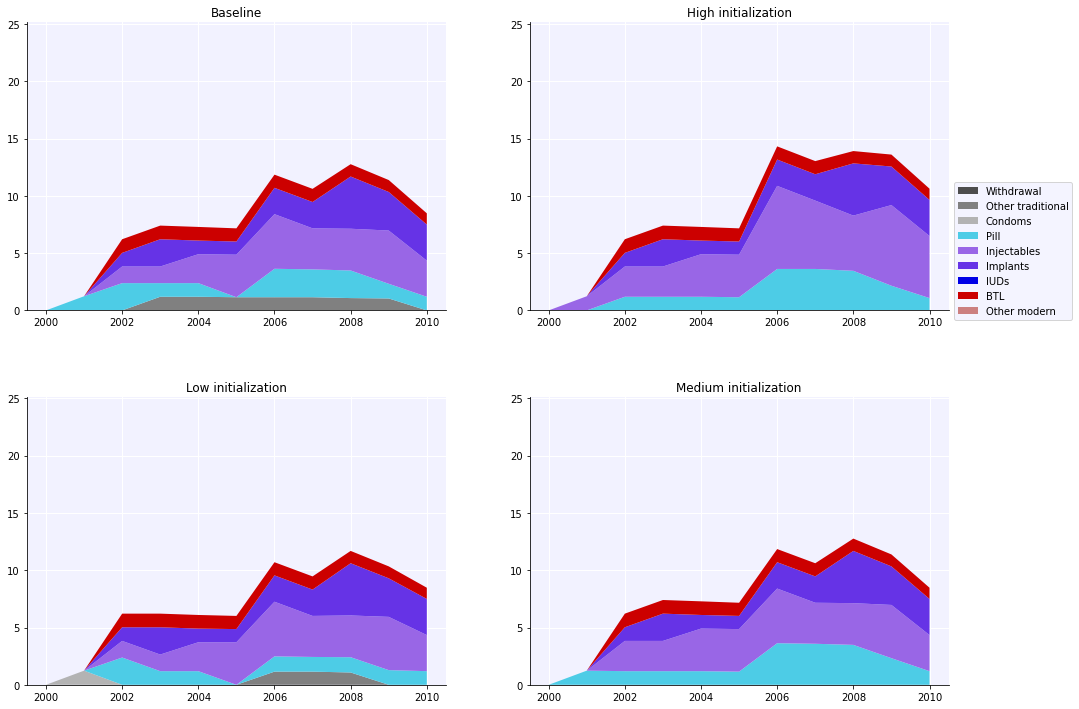

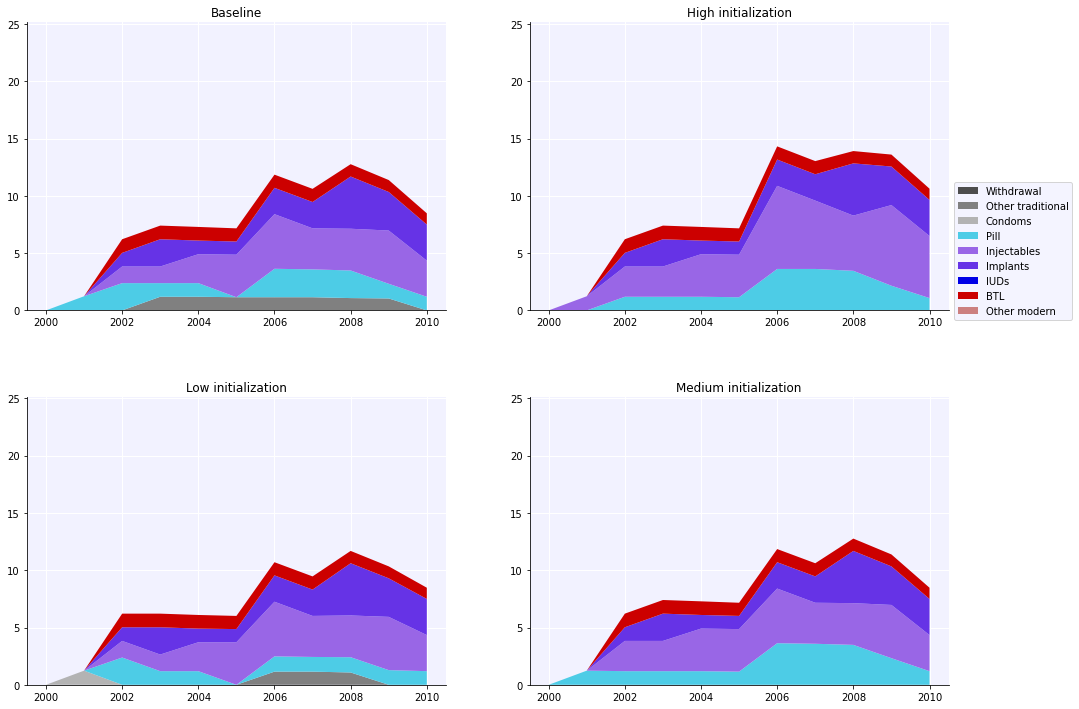

In [10]:
scens_initialization.plot(to_plot='method', colors=method_colors)

### **plot(to_plot='apo')**

We use 'apo' to specify that we want to analyze adverse pregnancy outcomes for each Scenario.

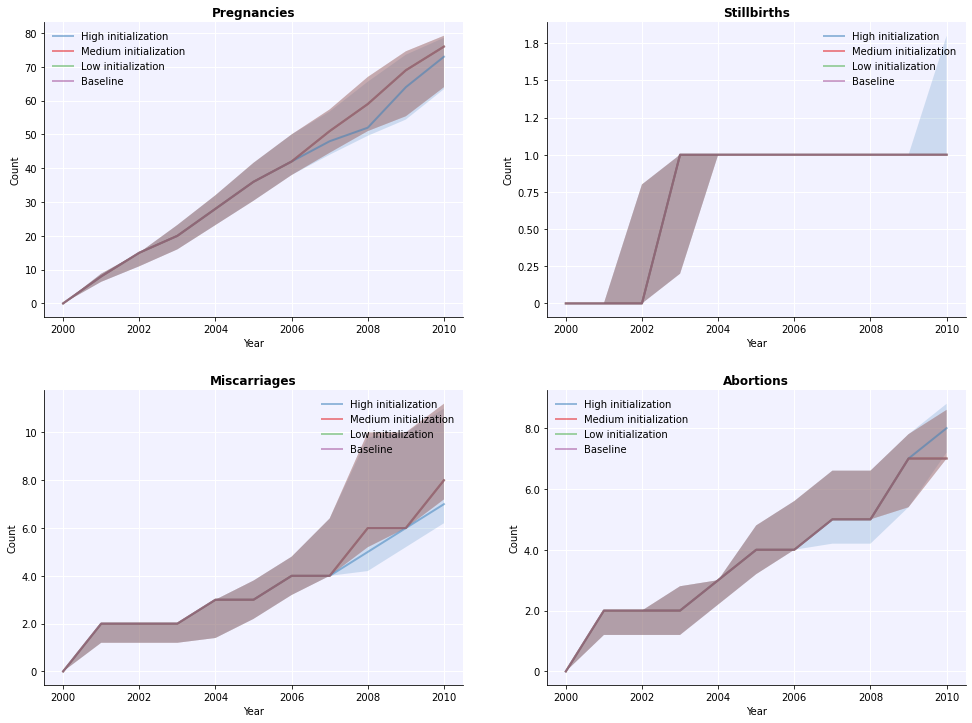

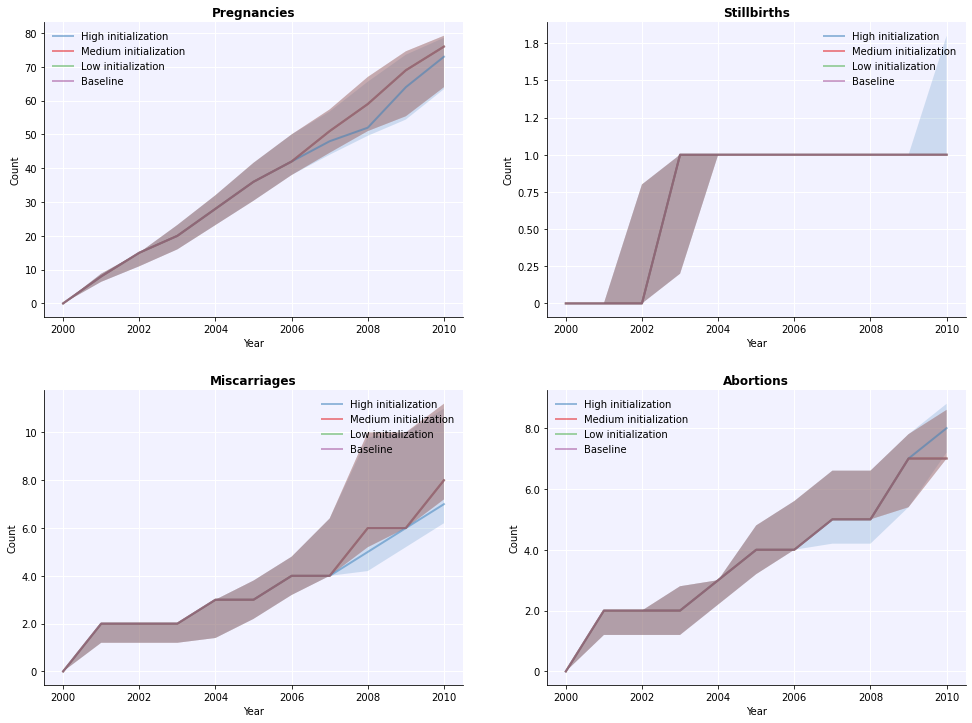

In [11]:
scens_initialization.plot(to_plot='apo')

### **plot(to_plot='cpr')**

We use 'cpr' to specify that we want to analyze contraceptive prevalence rates for each Scenario.

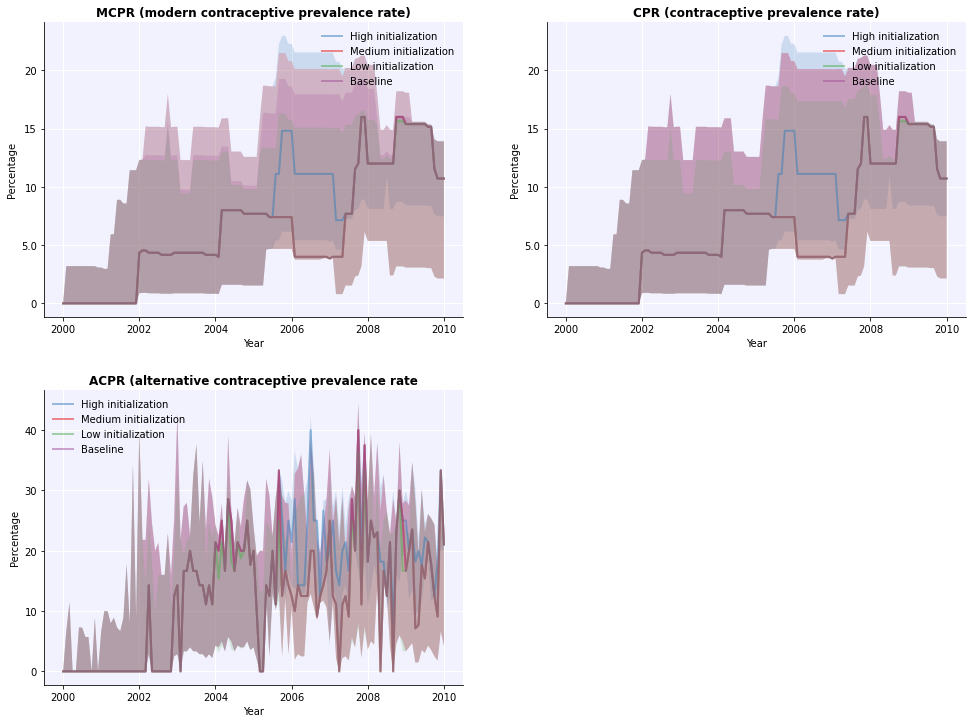

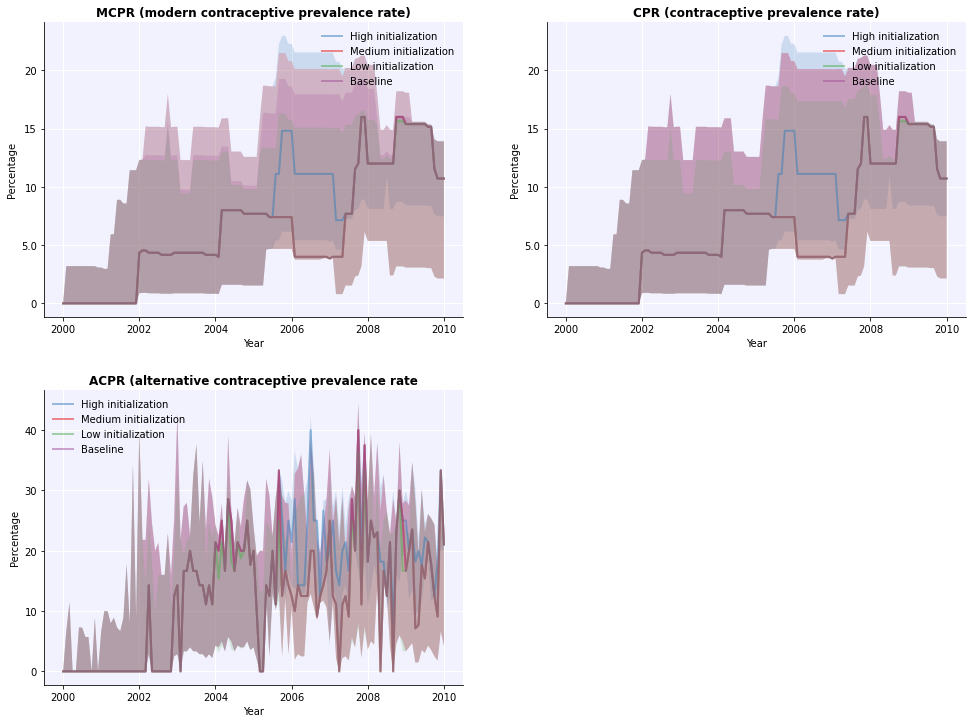

In [12]:
scens_initialization.plot(to_plot='cpr')

### **plot_sims()**

Plot sims is useful for when we want to understand the specific results of each individual sim for a given scenario. Although a group of sims for a single scenario should all have the same parameters, a difference in seed can produce a significant effect.

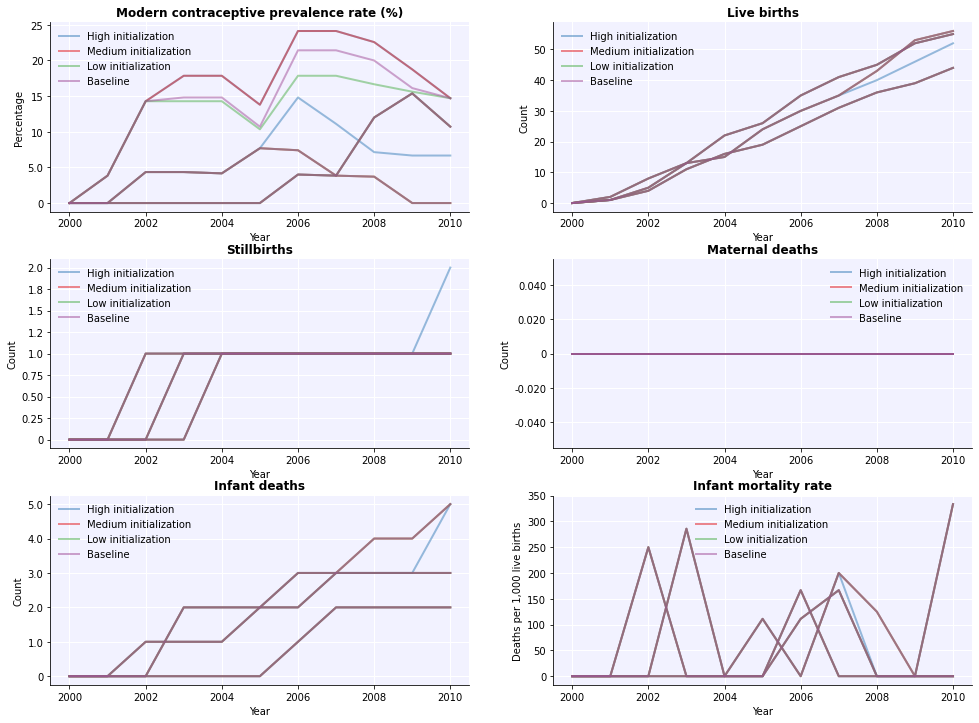

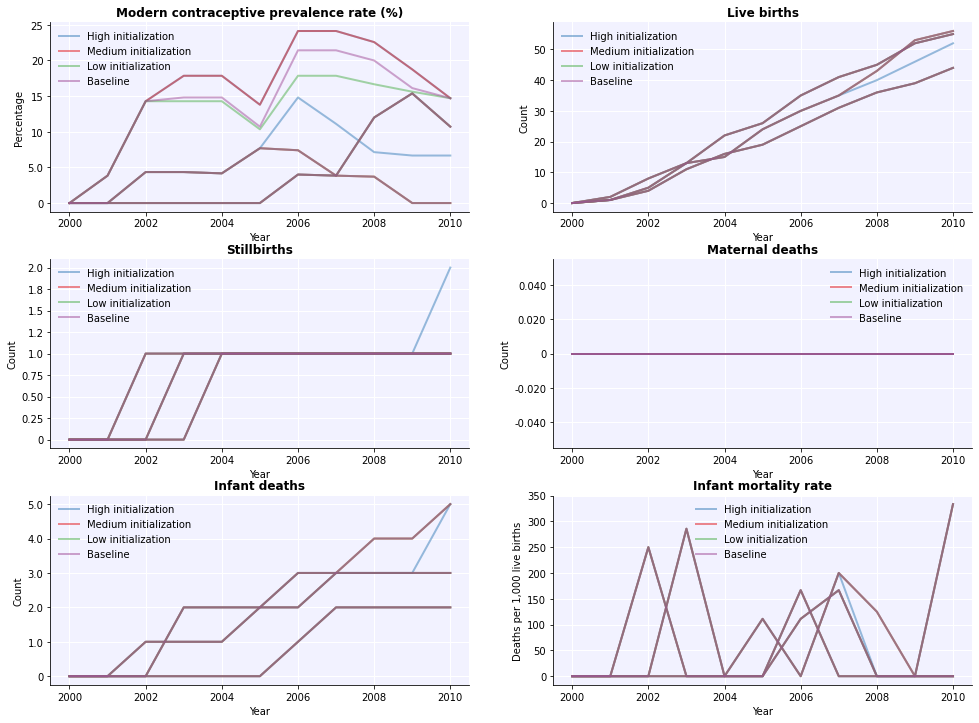

In [13]:
# Single scenario with 3 runs
scens_initialization.plot_sims()

### **analyze_sims()**

Lastly, if we want to create our own quick custom visualization or perform post hoc analysis, analyze_sims() let's us log the data as a dictionary or dataframe.

In [14]:
scens_initialization.analyze_sims()

,scenario,births,fails,popsize,tfr,infant_deaths,maternal_deaths,mcpr
0,Decreased efficacy of injectables,52.0,3.0,1305,5.174242,3.0,0.0,0.022337
1,Decreased efficacy of injectables,44.0,1.0,1290,6.255411,3.0,0.0,0.034515
2,Decreased efficacy of injectables,67.0,2.0,1393,6.255952,1.0,0.0,0.126158
3,Baseline,57.0,0.0,1321,5.681818,5.0,0.0,0.030313
4,Baseline,45.0,0.0,1291,6.352814,3.0,0.0,0.042682


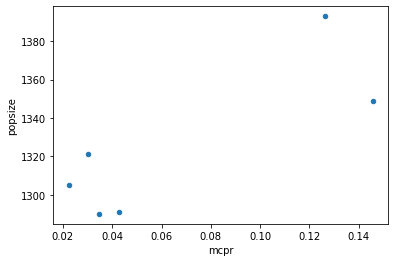

In [15]:
# Dataframe format let's use the built-in dataframe functions for a quick, aggregate view of the results
df = scenarios.results.df

ax = df.plot.scatter(x="mcpr", y="popsize")
df.head() # uncomment to see schema of DataFrame

In [16]:
# If we want some summary statistics on the results of the scenarios, we can view the results as a dictinary using .stats
scens_eff.results.stats

#0. 'mean':
    #0. 'births':          53.833333333333336
    #1. 'fails':           1.0
    #2. 'popsize':         1324.4166666666667
    #3. 'tfr':             5.812725468975469
    #4. 'infant_deaths':   2.9166666666666665
    #5. 'maternal_deaths': 0.0
    #6. 'mcpr':            0.06905315688380757
#1. 'median':
    #0. 'births':          56.0
    #1. 'fails':           0.0
    #2. 'popsize':         1320.0
    #3. 'tfr':             5.722402597402596
    #4. 'infant_deaths':   3.0
    #5. 'maternal_deaths': 0.0
    #6. 'mcpr':            0.0426818635909545
#2. 'std':
    #0. 'births':          7.312470322826768
    #1. 'fails':           1.35400640077266
    #2. 'popsize':         33.21259382958351
    #3. 'tfr':             0.47800202788090085
    #4. 'infant_deaths':   1.2555432644432805
    #5. 'maternal_deaths': 0.0
    #6. 'mcpr':            0.049772751375862866
#3. 'min':
    #0. 'births':          44.0
    #1. 'fails':           0.0
    #2. 'popsize':         1290
    #3. '

# Appendix <a name="appendix"></a>
#### An exhaustive list of arguments for the classes and functions used in this notebook
------------------------------------

# Objects
-----------------------------

### Scenario
*Arguments not specific to to the type of scenario:*

- **spec**   (dict): a pre-made specification of a scenario; see keyword explanations below (optional)


- **args**   (list): additional specifications (optional)


- **label**  (str): the label to use for this scenario for plotting output


- **pars**   (dict): optionally supply additional sim parameters to use with this scenario (that take effect at the beginning of the sim, not at the point of intervention)


- **year**   (float): the year at which to activate efficacy and probability scenarios


- **matrix** (str): which set of method probabilities to modify for probability scenarios, options are method probabilities for people who are one to six months postpartum,  up to one month postpartum, and all method probabilities respectively:

    ["pp1to6", "pp0to1", "annual"]
    


- **ages**   (str/list): the age group(s) targeted which can be any from :

     ['<18', '18-20', '21-25', '26-35', '>35', 'None', 'all']
     
     

*Arguments related to efficacy:*

- **eff**   (dict): a dictionary of method names and new efficacy values. Methods can be any from 

    ['None', 'Pill', 'IUDs', 'Injectables', 'Condoms', 'BTL', 'Withdrawal', 'Implants', 'Other traditional', 'Other modern')
    


*Argments related to method change probability*

- **source** (str): the method to switch from (enumerated above)


- **dest** (str): the method to switch to (enumerated above)


- **factor** (float): if supplied, multiply the probability of switching from source to dest by this amount


- **value** (float): if supplied instead of factor, replace the probability of switching from source to dest to this value


- **copy_from** (str): if supplied, copy probabilities from the given method


*Arguments related to initialization and discontinutation*

- **method** (str): name of the method that will have its initialization or discontinuation rate modified


- **init_factor** (float): as with "factor" above, for initialization (transition from None → method)


- **discont_factor** (float): as with "factor" above, for discontinuation (transition from method → None)


- **init_value** (float): as with "value" above, for initialization (transition from None → method)


- **discont_value** (float): as with "value" above, for discontinuation (transition from method → None)


*Arguments related to changing a parameter*

- **par** (str): the parameter to of the sim to modify, can be any of the parameters in sim.pars. For an exhaustive list of parameters that can be modified, one can use Scenarios.msims[0].pars.keys()


- **par_years** (float/list): the year(s) at which to apply the modifications, for example, 1960.0


- **par_vals** (float/list): the value(s) of the parameter for each year. If multiple values are provided, the length must match par_years


*Arguments related to custom interventions*

- **interventions** (Intervention/list): any custom intervention(s) to be applied to the scenario. This is a function of the format *intervention_name(sim)* which is applied to sim at each timestep


### Scenarios

*Arguments*

- **pars** (dict): parameters to pass into the sim. For example, {"n": 500} which modifies sim['n'] for each sim in Scenarios.msims


- **repeats** (int): how many repeats of each scenario to run to determine variation intervals in the output


- **scens** (list): the list of Scenario objects to run; see also fp.make_scen() and Scenarios.add_scen()


# Functions
-----------

### fpsim.make_scen(args, **kwargs)

*Arguments*

This contains all the same arguments as Scenario and is equivalent to calling Scenario(args)


### Scenarios.add_scen(scen=None, label=None)

*Arguments*

- **scen** (Scenario): Scenario object to be added to Scenarios


- **label** (str): sets Scenario.label for the Scenario object that is added

### Scenario(s).run(*args, **kwargs)

*Arguments*

This function passes all arguments directly into MultiSim.run(), so has the same arguments as MultiSim.run()



### Scenarios.plot(to_plot=None, plot_sims=True, **kwargs)

*Arguments*

- **to_plot** (str): specifies the type of plotting output. Can be any of 

    ["default", "cpr", "mortality", "apo"]
    
    for more information on what each of these types actually show, please refer to the [source code](https://github.com/amath-idm/fpsim/blob/4ce7f0cb59461cff560339e7a234514494c6f0b7/fpsim/sim.py#L1320)
    
    
- **plot_sims** (bool): whether to plot individual sims (else, plot with uncertainty bands)


- **kwargs**: other keyword arguments that are passed directly into MultiSim.plot()

### Scenarios.plot_sims(to_plot=None, plot_sims=True, **kwargs)

*Arguments*

- **to_plot** (str): same as above


- **plot_sims** (str): same as above


- **kwargs**: keyword arguments passed directly into MultiSim.plot() for each MutltiSim in Scenarios.msims

### Scenarios.analyze_sims(start=None, end=None)

*Arguments*

- **start** (float): the first year to be included in the output. By default this is the first year of the sim


- **end** (float): the last year to be included in the output. By default this is the last year in the sim

# Further Exploration
---------
### For more info check out the [source code](https://github.com/amath-idm/fpsim)